# FRET analysis - FLIM

This is a script to analyze FRET from 2D FLIM  images of cells transfected with different force sensors.
As controls, we use a donor only construct.

All images were acquired on our FCS 1 photon confocal microscope.


This script is meant to analyze files in an automatic way (nuclei segmentation, mask detection for the NE area, fluorescence intensity measurements in different channels, formatting of data, graphical representation...

## Workflow

1. open files
2. segment cells - find bounding box
3. Life time analysis => create a mask on the NE
4. draw a histogram of the Donor lifetime
5. save data along with metadata



This will already be a good start...

----

## Import libraries


In [1]:
%matplotlib inline


In [2]:
from readlif.reader import LifFile
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import skimage.filters
from skimage.io import imread, imshow
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
import skimage.measure
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd

#from photutils.detection import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.aperture import CircularAperture
from scipy import ndimage
from astropy.stats import sigma_clipped_stats
#from photutils.datasets import load_star_image
import os
from scipy.spatial.distance import canberra
from scipy.spatial.distance import pdist
import math
from itertools import combinations


import os
import seaborn as sns
from skimage import io, color


---

## Define folders and load data


In [6]:
# Define folders
date = '240807'

InputFolder = '/Users/christine/Documents/Data/DynamoLINC/FLIM/FLIM_240807/'
OutputFolder = '/Users/christine/Documents/Data/DynamoLINC/FLIM/FLIM_240807/Results/'



ls = os.listdir(InputFolder+'FLIMdata/')

names=[]
files=[]
for i in range(len(ls)):
    before, sep, after = ls[i].partition ('.')
    files.append(before)
    parts = before.split('-')
    name = parts[0]
    for i in range(1,len(parts)-1):
        name=name+'-'+parts[i]
    names.append(name)
construct = np.unique(names)

construct=list(filter(None,construct))
#files

In [7]:
construct


['CD153-control',
 'CD153-control-hypertonic',
 'CD154-control',
 'CD154-hypertonic',
 'CD158-control',
 'CD158-hypertonic']

In [5]:
# open FLIM file

for f in files:
    
## extract images 
    
    img_FLIM = io.imread(InputFolder+'FLIMdata/'+f+'.tif').astype(float)
    img_D = io.imread(InputFolder+f+'_Ch2.tif').astype(float)
    img_FRET = io.imread(InputFolder+f+'_Ch1.tif').astype(float)
        

    fig, (ax0,ax1,ax2) = plt.subplots(nrows=1,ncols=3, figsize=(6,2), constrained_layout=True)
    flim=ax2.imshow(img_FLIM)
    ax2.set_title('FLIM')
    ax2.axis('off')
    
    don=ax0.imshow(img_D, cmap='gray')
    ax0.set_title('Donor')
    ax0.axis('off')
    
    fret=ax1.imshow(img_FRET, cmap='gray')
    ax1.set_title('mRuby (FRET)')
    ax1.axis('off')
    fig.suptitle(f, fontsize=18)
    fig.colorbar(flim,ax=ax2)
    fig.colorbar(don,ax=ax0)
    fig.colorbar(fret, ax=ax1)
    plt.savefig(OutputFolder+f+'.tif')
    plt.close()
    plt.show()

print('Done !')



FileNotFoundError: [Errno 2] No such file or directory: '/Users/christine/Documents/Data/DynamoLINC/FLIM/FLIM_240807/CD158-hypertonic-5timelaps8_Ch2.tif'

si-CD153-fixed


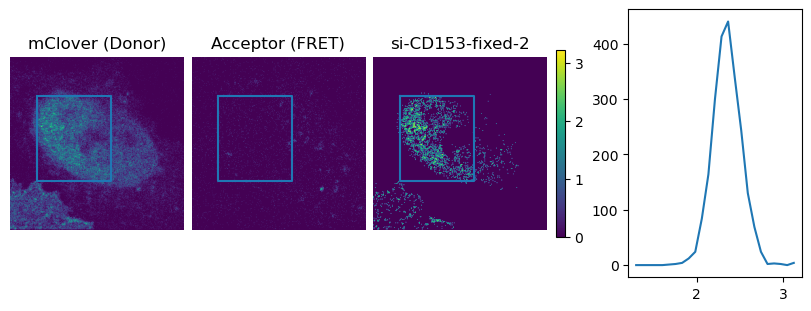

si-CD153-fixed


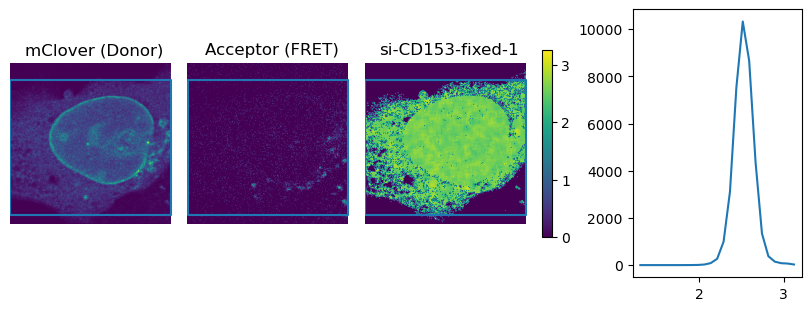

si-CD158-fixed


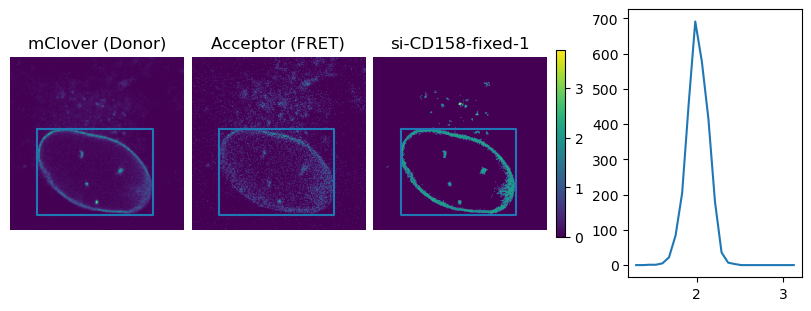

si-CD158-fixed


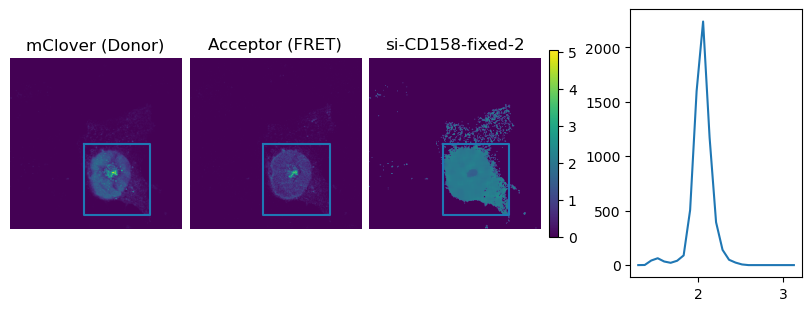

si-CD158-fixed


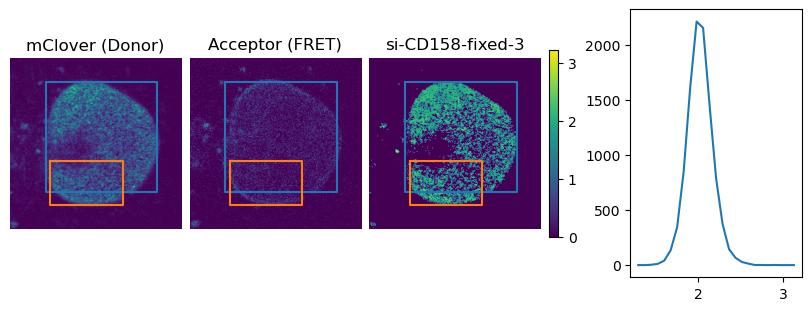

<Figure size 640x480 with 0 Axes>

si-CD158-fixed


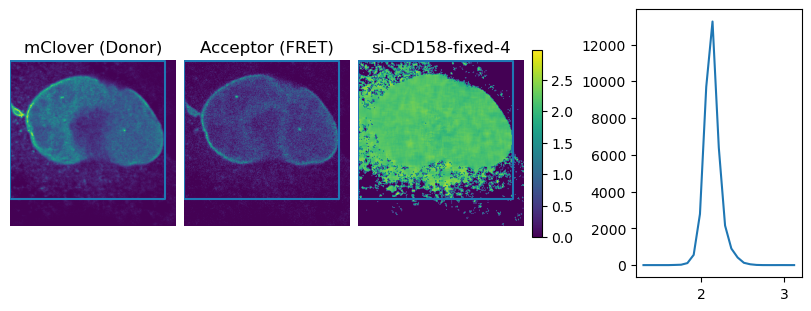

si-CD158-fixed


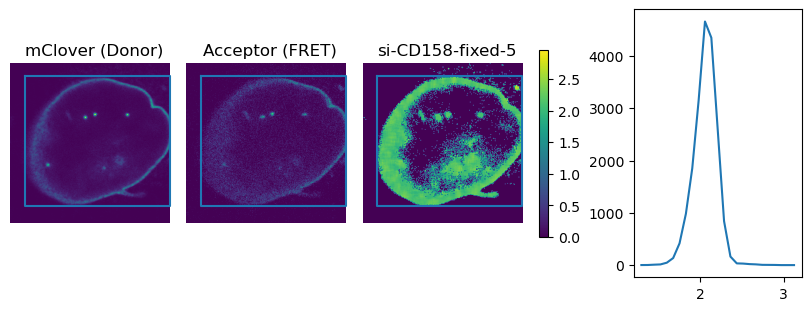

In [89]:
minval = 1.3
maxval = 3.2
b=25

#acceptor = ['mRuby2','mRuby2','mScarlet','mScarlet','mScarlet','none']
#position = ['CC','TM-CC1','TM','CC','TM-CC1','TM-CC1']

hist = []
condition = []

for f in files:
    
    
    parts = f.split('-')
    cond = parts[0]
    for i in range(1,len(parts)-1):
        cond = cond+'-'+parts[i]
    print(cond)
    
    h = np.zeros(b)
    
    #for j in range(9):
        #f=construct[i]+'-'+str(j+1)
        
        
    
    ## extract images 
    img_FLIM = io.imread(InputFolder+'FLIMdata/'+f+'.tif').astype(float)
    img_D = io.imread(InputFolder+f+'_Ch2.tif').astype(float)
    img_FRET = io.imread(InputFolder+f+'_Ch1.tif').astype(float)

    # denoise
    filtered_FLIM = ndimage.gaussian_filter(img_FLIM, sigma=1.5)
    # binarize
    t = skimage.filters.threshold_otsu(filtered_FLIM)
    mask = filtered_FLIM > t

    labeled_FLIM, count = skimage.measure.label(mask, connectivity=2,return_num=True)
    #print('number of nuclei: ',count)

    fig, (ax0,ax1,ax2,ax3) = plt.subplots(ncols=4, figsize=(8,3),constrained_layout=True)
    ax0.imshow(img_D)
    ax0.axis('off')
    ax0.set_title('mClover (Donor)')

    ax1.imshow(img_FRET)
    ax1.axis('off')
    ax1.set_title('Acceptor (FRET)')

    flim = ax2.imshow(img_FLIM)
    ax2.axis('off')
    ax2.set_title(f)
    fig.colorbar(flim,ax=ax2, shrink=0.7)

    #plt.show()

    props = regionprops_table(labeled_FLIM)
    regions=pd.DataFrame(props)


    # store the bounding boxes coordinates in an array called ROIs (size = count x 4)
    ROIs = np.zeros((count,4))
    cc=0
    for p in range(count):
        minx,miny,maxx,maxy = regions.iloc[p,1:5]


        bx=(miny,maxy,maxy,miny,miny)
        by=(minx,minx,maxx,maxx,minx)
        if maxx-minx >30 and maxy-miny>30:
            ROIs[cc] = minx,maxx,miny,maxy
            #print(minx)
            ax0.plot(bx,by)
            ax1.plot(bx,by)
            ax2.plot(bx,by)
            cc=cc+1


    #plt.show()

    for c in range(cc):
        r=ROIs[c,:]
        minx,maxx,miny,maxy = r.astype(int)
        ROI = img_FLIM[minx:maxx,miny:maxy]

        histogram, bin_edges = np.histogram(ROI, bins=b, range=(minval, maxval))


        h = h+histogram

        ax3.plot(bin_edges[0:-1], histogram)
        #plt.savefig('/Users/christine/Documents/Data/DynamoLINC/FLIM/Results/'+f+'_histo.tif')
        #plt.imshow(ROI)

        plt.savefig(OutputFolder+f+'_histo.tif')
        plt.savefig(OutputFolder+f+'_histo.jpg')
        plt.show()
        #plt.close()


    hist.append(h)
    condition.append(cond)
    
df = pd.DataFrame()
df['Histogram'] = hist[:]
df['Construct'] = condition[:]
        

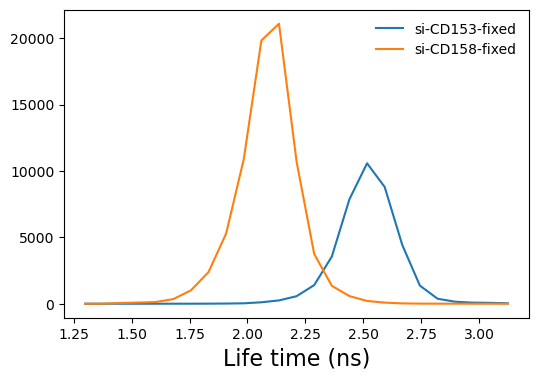

In [92]:
## Compile all histograms   
fig, ax = plt.subplots(figsize=(6,4))

exp=[]
histogram=[]
condition=[]

for i in range(2):
    cond = construct[i]
    hist= df.loc[df['Construct'] == cond, 'Histogram'].sum()
    ax.plot(bin_edges[0:-1], hist, label=cond)
    ax.set_xlabel('Life time (ns)', fontsize=16)
    plt.legend(frameon=False)
    
    exp.append(date)
    histogram.append(hist)
    condition.append(cond)

plt.savefig(OutputFolder+'combined_histo.tif')
plt.savefig(OutputFolder+'combined_histo.jpg')

compiled_hist = pd.DataFrame()
compiled_hist['Date'] = exp[:]
compiled_hist['Lifetime_histo'] = histogram[:]
compiled_hist['Construct'] = condition[:]

compiled_hist.to_csv(OutputFolder+'compiled_results.csv')

ValueError: x and y must have same first dimension, but have shapes (25,) and (1,)

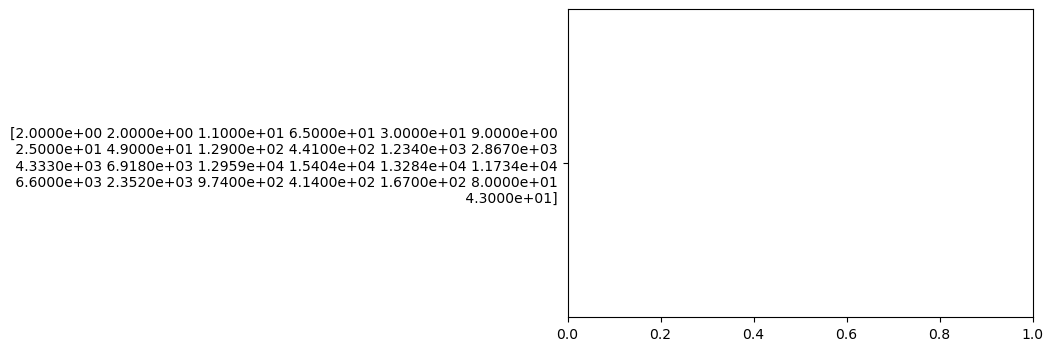

In [162]:
## Compile results from different experiments

date = ['240207','240208']
df = pd.DataFrame(columns=['Date','Lifetime_histo','Construct'])

for i in range(len(date)):
    d=date[i]
    Folder = '/Users/christine/Documents/Data/DynamoLINC/FLIM/FLIM_230913/'+d+'/Results/'
    df_d = pd.read_csv(Folder+'compiled_results.csv')
    df=pd.concat([df,df_d],ignore_index=True)
    
df.to_csv('/Users/christine/Documents/Data/DynamoLINC/FLIM/'+'compiled_lifetime_histo.csv')

## Plot compiled histograms
fig, ax = plt.subplots(figsize=(6,4))

for i in range(len(df)):
    cond = df['Construct'][i]
    hist= df.loc[df['Construct'] == cond, 'Lifetime_histo'].values
    ax.plot(bin_edges[0:-1], hist, label=cond)
    ax.set_xlabel('Life time (ns)', fontsize=16)
    plt.legend(frameon=False)
    

In [163]:
hist

array(['[2.0000e+00 2.0000e+00 1.1000e+01 6.5000e+01 3.0000e+01 9.0000e+00\n 2.5000e+01 4.9000e+01 1.2900e+02 4.4100e+02 1.2340e+03 2.8670e+03\n 4.3330e+03 6.9180e+03 1.2959e+04 1.5404e+04 1.3284e+04 1.1734e+04\n 6.6000e+03 2.3520e+03 9.7400e+02 4.1400e+02 1.6700e+02 8.0000e+01\n 4.3000e+01]'],
      dtype=object)

---

## NE detection and FLIM analysis on NE

Here I want to 
- define a mask for the NE and analyse the lifetimes in the NE only
- for each nucleus, calculate the mean lifetime and standard deviation, and the lifetime histogram.
- concatenate results for each construct
- show the results as histograms and boxplots

In a first version, I try to segment directly on the donor image. But if levels are too heterogenous, some low expressing cells may be missed. In this case I will have to segment on FLIM image first, crop the obatined regions, then segment again on donor signal.

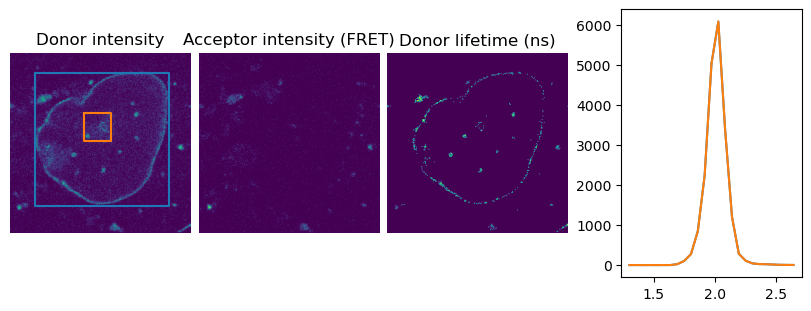

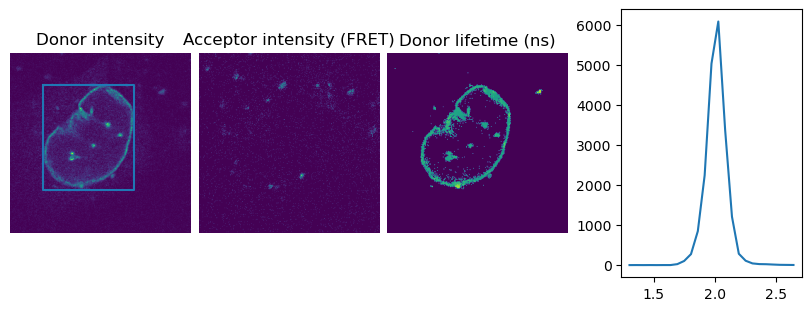

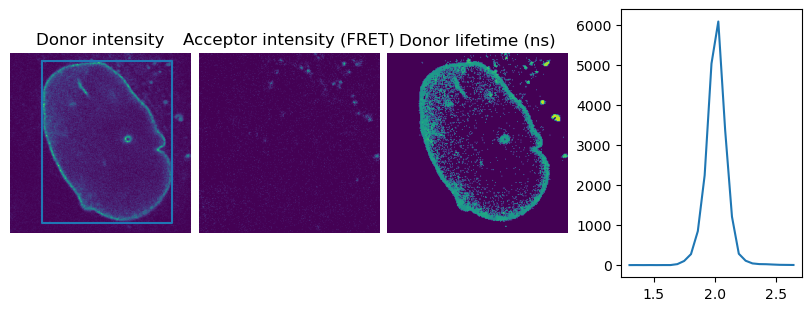

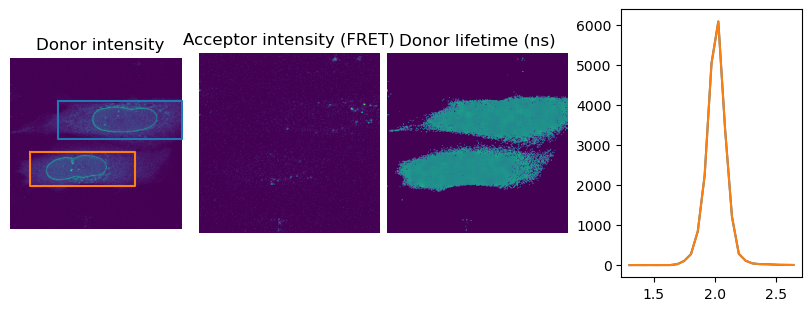

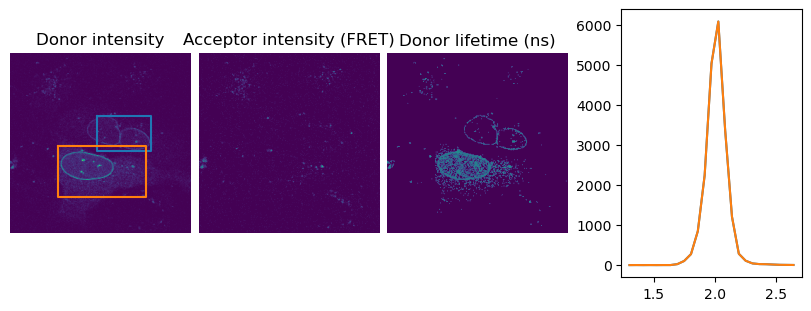

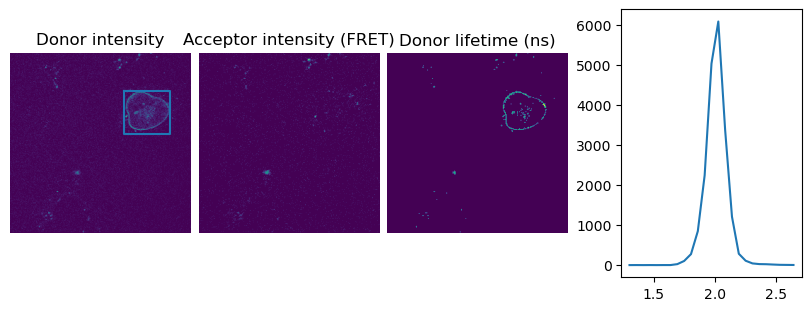

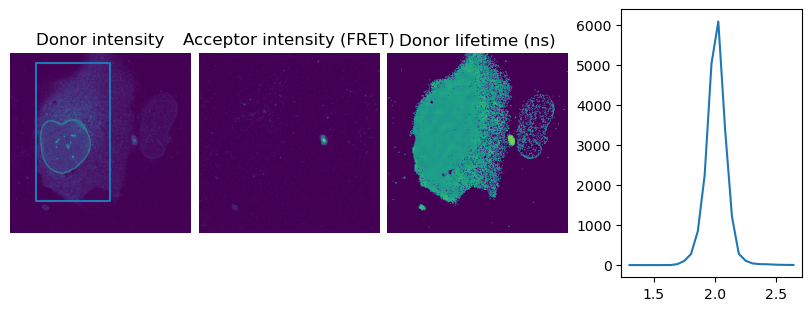

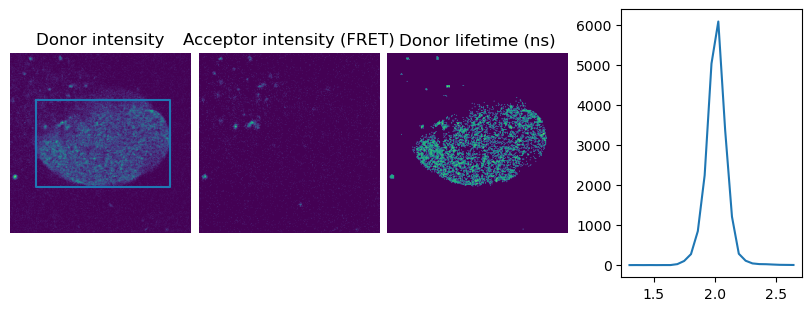

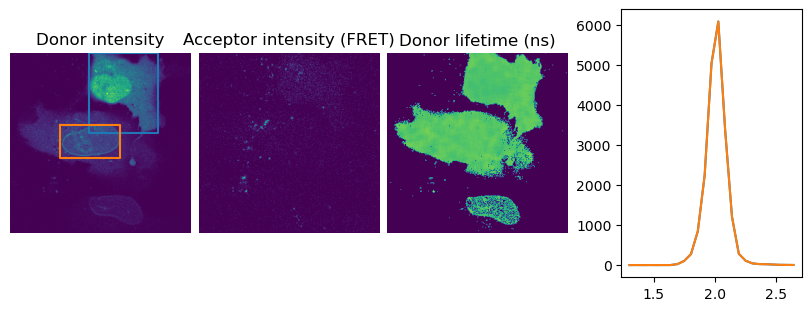

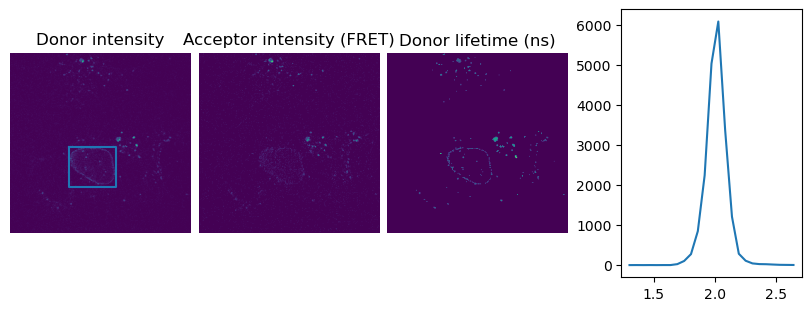

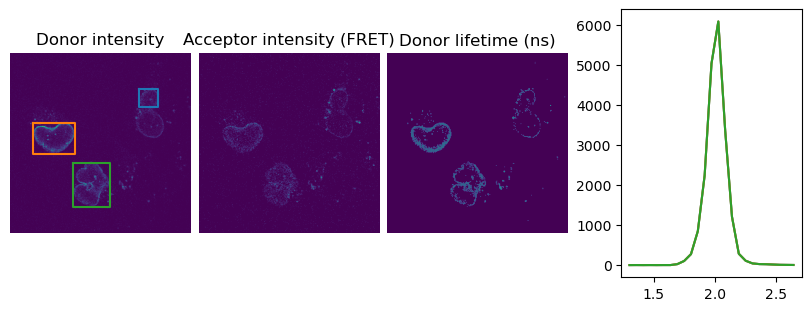

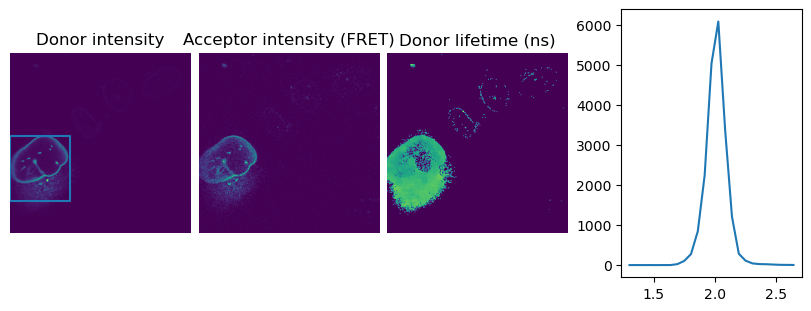

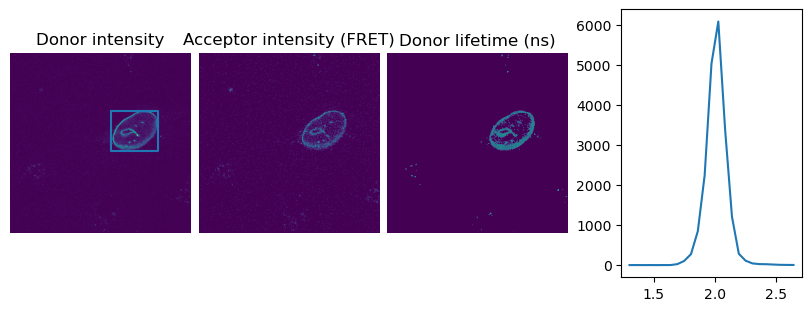

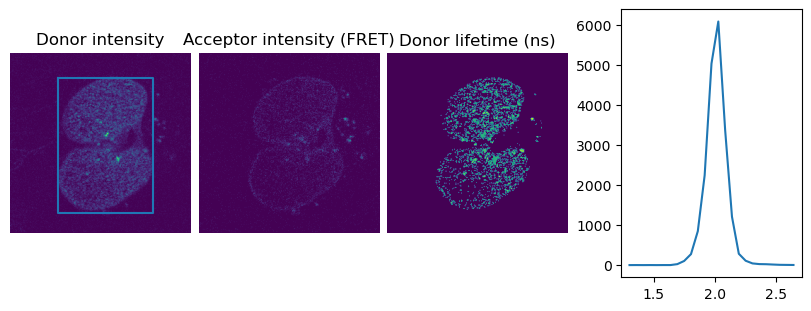

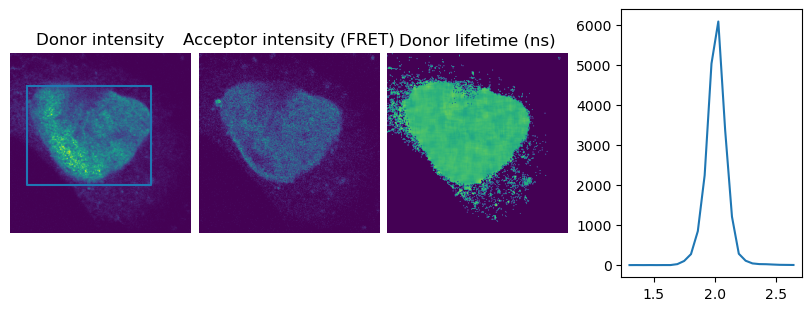

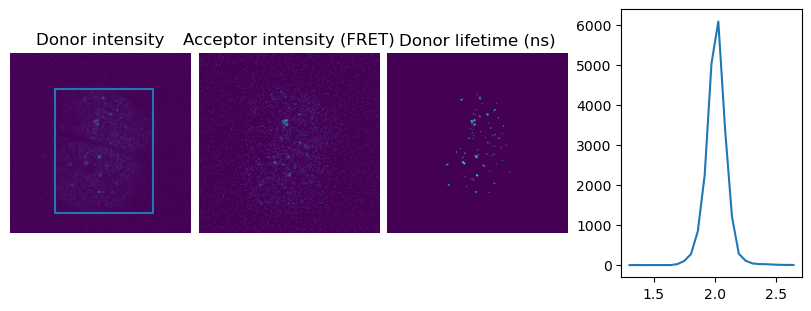

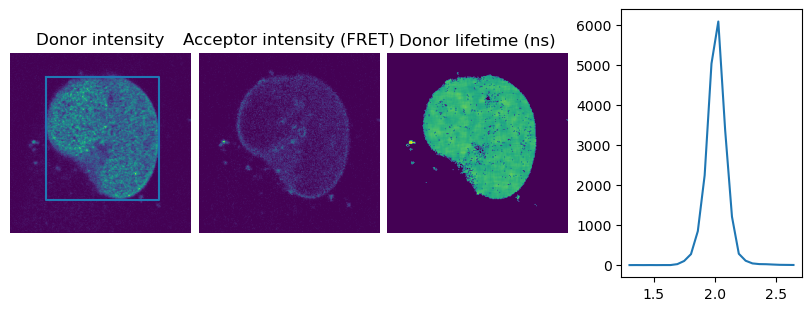

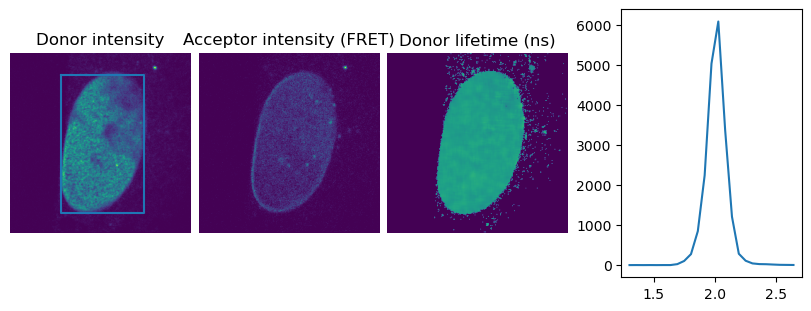

In [35]:
minval = 1.3
maxval = 2.7
b=25


hist_ER = []
hist_EN = []

img_name=[]
constr=[]
nucleus=[]
mean=[]
st=[]

#acc = []
#pos = []

for i in range(2):

    h_EN = np.zeros(b)
    
    
    for j in range(9):
        f=construct[i]+'-'+str(j+1)
        
        fig, (ax0,ax1,ax2,ax3) = plt.subplots(ncols=4, figsize=(8,3),constrained_layout=True)
        #fig.suptitle(str(f))
    
    ## extract images 
        img_FLIM = io.imread(InputFolder+'FLIMdata/'+f+'.tif').astype(float)
        img_D = io.imread(InputFolder+f+'_Ch2.tif').astype(float)
        img_FRET = io.imread(InputFolder+f+'_Ch1.tif').astype(float)
        
        ax0.imshow(img_D)
        ax0.axis('off')
        ax0.set_title('Donor intensity')
        
        ax1.imshow(img_FRET)
        ax1.axis('off')
        ax1.set_title('Acceptor intensity (FRET)')
        
        ax2.imshow(img_FLIM)
        ax2.axis('off')
        ax2.set_title('Donor lifetime (ns)')
        

        # denoise
        filtered_D = ndimage.gaussian_filter(img_D, sigma=1.5)
        # binarize
        t = skimage.filters.threshold_otsu(filtered_D)
        mask = filtered_D > t
        masked_FLIM = img_FLIM*mask

        labeled_D, count = skimage.measure.label(mask, connectivity=2,return_num=True)
        #print('number of nuclei: ',count)

        props = regionprops_table(labeled_D)
        regions=pd.DataFrame(props)


        # store the bounding boxes coordinates in an array called ROIs (size = count x 4)
        ROIs = np.zeros((count,4))
        cc=0
        for p in range(count):
            
            
            minx,miny,maxx,maxy = regions.iloc[p,1:5]


            bx=(miny,maxy,maxy,miny,miny)
            by=(minx,minx,maxx,maxx,minx)
            # remove objects that are too small and count them in cc
            if maxx-minx >20 and maxy-miny>20:
                ROIs[cc] = minx,maxx,miny,maxy
                ax0.plot(bx,by)
                #print(minx)
                cc=cc+1

        # crop images around segmented NEs
        for c in range(cc):
            img_name.append(str(f))
            constr.append(construct[i])
            nucleus.append(c)
            #acc.append(acceptor[i])
            #pos.append(position[i])
            
            r=ROIs[c,:]
            minx,maxx,miny,maxy = r.astype(int)
            ROI = img_FLIM[minx:maxx,miny:maxy]
            filtered_ROI = ndimage.gaussian_filter(ROI, sigma=1.5)
            filtered_D = ndimage.gaussian_filter(img_D[minx:maxx,miny:maxy], sigma=1.5)
        
            # binarize
            t2 = skimage.filters.threshold_otsu(filtered_D)            
            mask2 = filtered_D > t2
            

    
## EN segmentation
            
            labeled_EN, count2 = skimage.measure.label(mask2, connectivity=2,return_num=True)
        
## EN lifetime 
        
            FLIM_EN = ROI*mask2
            mean.append(np.mean(FLIM_EN[FLIM_EN != 0]))
            st.append(np.std(FLIM_EN[FLIM_EN != 0]))
            histogram_EN, bin_edges = np.histogram(FLIM_EN, bins=25, range=(minval, maxval))            
            h_EN = h_EN+histogram_EN #np.concatenate((histo_EN,histogram_EN), axis=0)
            
        

            ax3.plot(bin_edges[0:-1], histogram)
            #plt.savefig('/Users/christine/Documents/Data/DynamoLINC/FLIM/Results/'+f+'_histo.tif')
            #plt.imshow(ROI)
        
            plt.savefig(OutputFolder+f+'_histo.tif')
            plt.savefig(OutputFolder+f+'_histo.jpg')
            #plt.show()
        

    
    hist_EN.append(h_EN)
                        

In [36]:
df = pd.DataFrame()
df['Name'] = img_name[:]
df['Construct'] = constr[:]  
#df['Acceptor'] = acc[:]
#df['Position'] = pos[:]
df['Nucleus #'] = nucleus[:]
df['Mean lifetime (ns)'] = mean[:]
df['Standard deviation'] = st[:]

df.to_csv(OutputFolder+'Lifetimes_wholeCells.csv', index=False)

df                        
        

Name Construct  Nucleus #  Mean lifetime (ns)  Standard deviation
0   si-CD153-1  si-CD153          0            2.141741            0.279435
1   si-CD153-1  si-CD153          1            2.013890            0.128776
2   si-CD153-2  si-CD153          0            2.285452            0.194885
3   si-CD153-3  si-CD153          0            2.291439            0.190194
4   si-CD153-4  si-CD153          0            2.454671            0.096078
5   si-CD153-4  si-CD153          1            2.450597            0.086909
6   si-CD153-5  si-CD153          0            2.404448            0.270078
7   si-CD153-5  si-CD153          1            2.376370            0.171489
8   si-CD153-6  si-CD153          0            2.232535            0.244906
9   si-CD153-7  si-CD153          0            2.439729            0.085513
10  si-CD153-8  si-CD153          0            2.406461            0.133747
11  si-CD153-9  si-CD153          0            2.586547            0.062337
12  si-CD153-9  si-CD153          1            2.632745            0.047435
13  si-CD158-1  si-CD158          0            1.970839            0.272729
14  si-CD158-2  si-CD158          0            2.068252            0.268986
15  si-CD158-2  si-CD158          1            2.036177            0.130730
16  si-CD158-2  si-CD158          2            1.982720            0.206699
17  si-CD158-3  si-CD158          0            1.985080            0.093519
18  si-CD158-4  si-CD158          0            1.958231            0.125527
19  si-CD158-5  si-CD158          0            1.935968            0.170314
20  si-CD158-6  si-CD158          0            2.049303            0.076249
21  si-CD158-7  si-CD158          0            2.057311            0.278639
22  si-CD158-8  si-CD158          0            1.991331            0.104567
23  si-CD158-9  si-CD158          0            2.045405            0.063505

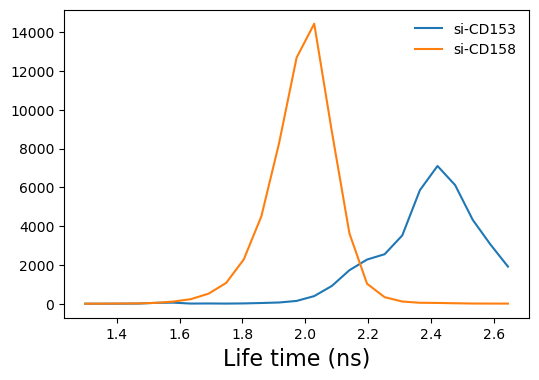

In [38]:
fig, ax = plt.subplots(figsize=(6,4))
for i in range(2):
    ax.plot(bin_edges[0:-1], hist_EN[i], label=construct[i])
    ax.set_xlabel('Life time (ns)', fontsize=16)
    plt.legend(frameon=False)

plt.savefig(OutputFolder+'combined_histo_EN.tif')
plt.savefig(OutputFolder+'combined_histo_EN.jpg')

In [6]:
df = pd.read_csv(OutputFolder+'Lifetimes_wholeCells.csv')
df

Name Construct Acceptor Position  Nucleus #  Mean lifetime (ns)  \
0     CD150_1     CD150   mRuby2       CC          0            2.123516   
1     CD150_1     CD150   mRuby2       CC          1            2.191261   
2     CD150_2     CD150   mRuby2       CC          0            2.140823   
3     CD150_2     CD150   mRuby2       CC          1            2.096515   
4     CD150_2     CD150   mRuby2       CC          2            1.979334   
..        ...       ...      ...      ...        ...                 ...   
104   CD153_6     CD153     none   TM-CC1          0            2.213607   
105   CD153_7     CD153     none   TM-CC1          0            2.260886   
106   CD153_8     CD153     none   TM-CC1          0            2.245862   
107   CD153_9     CD153     none   TM-CC1          0            2.247398   
108  CD153_10     CD153     none   TM-CC1          0            2.252301   

     Standard deviation  
0              0.080942  
1              0.047961  
2              0.056369  
3              0.044646  
4              0.050768  
..                  ...  
104            0.032111  
105            0.030589  
106            0.033852  
107            0.050324  
108            0.054889  

[109 rows x 7 columns]

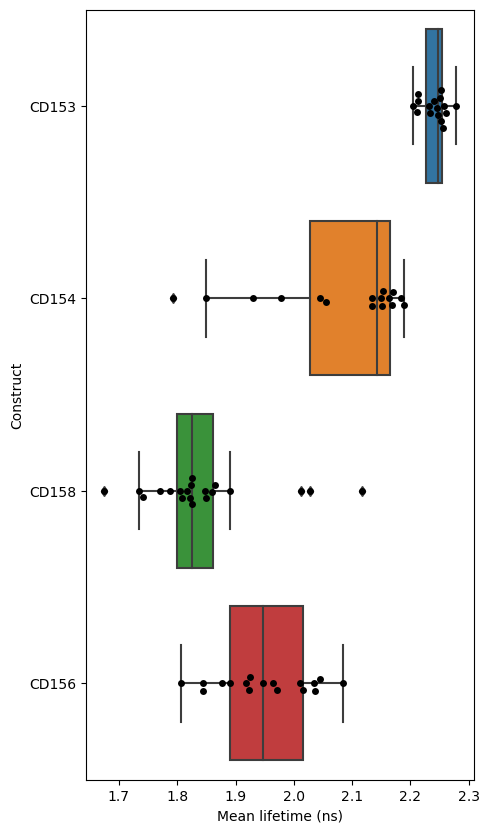

In [15]:
import seaborn as sns
constr_order=['CD153','CD154','CD158','CD156']
#constr_order=['TM','CC','TM-CC1']

fig, ax = plt.subplots(figsize = (5,10))
sns.boxplot(y=df['Construct'], x=df['Mean lifetime (ns)'], data=df,order=constr_order, ax=ax )
sns.swarmplot(y=df['Construct'], x=df['Mean lifetime (ns)'], data=df, order=constr_order,color='k',legend=False, ax=ax)

plt.savefig(OutputFolder+'Boxplot.jpg')

In [62]:
print(len(np.unique(img_name)))

59


In [81]:
minval = 1.3
maxval = 2.7
b=25
construct = ['CD150','CD151','CD153','CD154','CD156','CD158']

hist_ER = []
hist_EN = []

for i in range(6):

    h_EN = np.zeros(b)
    h_ER = np.zeros(b)
    
    for j in range(10):
        f=construct[i]+'_'+str(j+1)
    
    ## extract images 
        img_FLIM = io.imread(InputFolder+'FLIMdata/'+f+'_FLIM.tif').astype(float)
        img_D = io.imread(InputFolder+f+'_Ch2.tif').astype(float)
        img_FRET = io.imread(InputFolder+f+'_Ch1.tif').astype(float)

        # denoise
        filtered_FLIM = ndimage.gaussian_filter(img_FLIM, sigma=1.5)
        # binarize
        t = skimage.filters.threshold_otsu(filtered_FLIM)
        mask = filtered_FLIM > t

        labeled_FLIM, count = skimage.measure.label(mask, connectivity=2,return_num=True)
        #print('number of nuclei: ',count)

        props = regionprops_table(labeled_FLIM)
        regions=pd.DataFrame(props)


        # store the bounding boxes coordinates in an array called ROIs (size = count x 4)
        ROIs = np.zeros((count,4))
        cc=0
        for p in range(count):
            minx,miny,maxx,maxy = regions.iloc[p,1:5]


            bx=(miny,maxy,maxy,miny,miny)
            by=(minx,minx,maxx,maxx,minx)
            if maxx-minx >30 and maxy-miny>30:
                ROIs[cc] = minx,maxx,miny,maxy
                #print(minx)
                cc=cc+1

        for c in range(cc):
            r=ROIs[c,:]
            minx,maxx,miny,maxy = r.astype(int)
            ROI = img_FLIM[minx:maxx,miny:maxy]
            filtered_ROI = ndimage.gaussian_filter(ROI, sigma=1.5)
            filtered_D = ndimage.gaussian_filter(img_D[minx:maxx,miny:maxy], sigma=1.5)
        
            # binarize
            t1 = skimage.filters.threshold_otsu(filtered_ROI)
            mask1 = ROI > t1
            #print(mask1.shape)
            t2 = skimage.filters.threshold_otsu(filtered_D)
            #print(t2)
            mask2 = filtered_D > t2
            mask3 = mask2^mask1

    
## EN and ER segmentation

            labeled_ROI, count1 = skimage.measure.label(mask1, connectivity=2,return_num=True)
            labeled_EN, count2 = skimage.measure.label(mask2, connectivity=2,return_num=True)
            labeled_ER, count3 = skimage.measure.label(mask3, connectivity=2,return_num=True)
        
## EN and ER lifetime 
        
            FLIM_ER = ROI*mask3
            FLIM_EN = ROI*mask2

            histogram_ER, bin_edges = np.histogram(FLIM_ER, bins=25, range=(minval, maxval))
            histogram_EN, bin_edges = np.histogram(FLIM_EN, bins=25, range=(minval, maxval))
        
        
            h_ER = h_ER+histogram_ER #np.concatenate((histo_ER,histogram_ER), axis=0)
            h_EN = h_EN+histogram_EN #np.concatenate((histo_EN,histogram_EN), axis=0)
            
        

            ax3.plot(bin_edges[0:-1], histogram)
            #plt.savefig('/Users/christine/Documents/Data/DynamoLINC/FLIM/Results/'+f+'_histo.tif')
            #plt.imshow(ROI)
        
            plt.savefig(OutputFolder+f+'_histo.tif')
            plt.savefig(OutputFolder+f+'_histo.jpg')
            plt.show()
        

    hist_ER.append(h_ER)
    hist_EN.append(h_EN)
    
print('Done !!')
        

number of nuclei:  3


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  2


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  4


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  2


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  4


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  5


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  16


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  7


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  3


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  3


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  12


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  2


<Figure size 640x480 with 0 Axes>

number of nuclei:  4


<Figure size 640x480 with 0 Axes>

number of nuclei:  7


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  3


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  9


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  12


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  13


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  21


<Figure size 640x480 with 0 Axes>

number of nuclei:  3


<Figure size 640x480 with 0 Axes>

number of nuclei:  9


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  8


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  5


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  7


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  4


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  3


<Figure size 640x480 with 0 Axes>

number of nuclei:  4


<Figure size 640x480 with 0 Axes>

number of nuclei:  15


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  8


<Figure size 640x480 with 0 Axes>

number of nuclei:  2


<Figure size 640x480 with 0 Axes>

number of nuclei:  2


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  10


<Figure size 640x480 with 0 Axes>

number of nuclei:  6


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  2


<Figure size 640x480 with 0 Axes>

number of nuclei:  7


<Figure size 640x480 with 0 Axes>

number of nuclei:  5


<Figure size 640x480 with 0 Axes>

number of nuclei:  2


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  6


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  16


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  9


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  4


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  21


<Figure size 640x480 with 0 Axes>

number of nuclei:  2


<Figure size 640x480 with 0 Axes>

number of nuclei:  5


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  1


<Figure size 640x480 with 0 Axes>

number of nuclei:  5


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  3


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  1


<Figure size 640x480 with 0 Axes>

number of nuclei:  7


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  10


<Figure size 640x480 with 0 Axes>

number of nuclei:  4


<Figure size 640x480 with 0 Axes>

number of nuclei:  5


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  9


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  13


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  6


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  20


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  9


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  2


<Figure size 640x480 with 0 Axes>

number of nuclei:  6


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

number of nuclei:  17


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Done !!


In [80]:
minval = 1.3
maxval = 2.7

b=25

h_ER = np.zeros(b)
h_EN = np.zeros(b)

for f in files:
    
## extract images 
    print(f)
    img_FLIM = io.imread(InputFolder+'FLIMdata/'+f+'_FLIM.tif').astype(float)
    img_D = io.imread(InputFolder+f+'_Ch2.tif').astype(float)
    img_FRET = io.imread(InputFolder+f+'_Ch1.tif').astype(float)
    
    # denoise
    filtered_FLIM = ndimage.gaussian_filter(img_FLIM, sigma=1.5)
    t = skimage.filters.threshold_otsu(filtered_FLIM)
    mask = filtered_FLIM > t
    labeled_FLIM, count = skimage.measure.label(mask, connectivity=2,return_num=True)
    
    #crop cells
    props = regionprops_table(labeled_FLIM)
    regions=pd.DataFrame(props)

    
    # store the bounding boxes coordinates in an array called ROIs (size = count x 4)
    ROIs = np.zeros((count,4))
    cc=0
    for p in range(count):
        minx,miny,maxx,maxy = regions.iloc[p,1:5]


        bx=(miny,maxy,maxy,miny,miny)
        by=(minx,minx,maxx,maxx,minx)
        #print(bx,by)
        if maxx-minx >20 and maxy-miny>20:
            ROIs[cc] = minx,maxx,miny,maxy
            #print(minx)
            
            cc=cc+1
    
        
    #plt.show()
    
    for i in range(cc):
        r=ROIs[i,:]
        #print(r)
        minx,maxx,miny,maxy = r.astype(int)
        ROI = img_FLIM[minx:maxx,miny:maxy]
        filtered_ROI = ndimage.gaussian_filter(ROI, sigma=1.5)
        filtered_D = ndimage.gaussian_filter(img_D[minx:maxx,miny:maxy], sigma=1.5)
        
        # binarize
        t1 = skimage.filters.threshold_otsu(filtered_ROI)
        mask1 = ROI > t1
        #print(mask1.shape)
        t2 = skimage.filters.threshold_otsu(filtered_D)
        #print(t2)
        mask2 = filtered_D > t2
        mask3 = mask2^mask1

    
## EN and ER segmentation

        labeled_ROI, count1 = skimage.measure.label(mask1, connectivity=2,return_num=True)
        labeled_EN, count2 = skimage.measure.label(mask2, connectivity=2,return_num=True)
        labeled_ER, count3 = skimage.measure.label(mask3, connectivity=2,return_num=True)
        
## EN and ER lifetime 
        
        FLIM_ER = ROI*mask3
        FLIM_EN = ROI*mask2
        
        histogram_ER, bin_edges = np.histogram(FLIM_ER, bins=25, range=(minval, maxval))
        histogram_EN, bin_edges = np.histogram(FLIM_EN, bins=25, range=(minval, maxval))
        
        if 'CD153' in f:
            hClo_ER = hClo_ER+histogram_ER #np.concatenate((histo_ER,histogram_ER), axis=0)
            hClo_EN = hClo_EN+histogram_EN #np.concatenate((histo_EN,histogram_EN), axis=0)
            
        else:
            hFS_ER = hClo_ER+histogram_ER #np.concatenate((histo_ER,histogram_ER), axis=0)
            hFS_EN = hClo_EN+histogram_EN #np.concatenate((histo_EN,histogram_EN), axis=0)

## representation

        fig, (ax0,ax1,ax2,ax3) = plt.subplots(ncols=4, figsize=(16,6),constrained_layout=True)
        flim=ax0.imshow(ROI)
        fig.colorbar(flim, ax=ax0, shrink = 0.7)
        ax0.axis('off')
        ax0.set_title('FLIM',fontsize=20)

        en=ax1.imshow(FLIM_EN, cmap='viridis')
        fig.colorbar(en, ax=ax1, shrink = 0.7)
        ax1.axis('off')
        ax1.set_title('EN',fontsize=20)

        er= ax2.imshow(FLIM_ER, cmap='viridis')
        fig.colorbar(er, ax=ax2, shrink = 0.7)
        ax2.axis('off')
        ax2.set_title('ER',fontsize=20)
        
        ax3.plot(bin_edges[0:-1],histogram_EN, label = 'EN',color='darkviolet', linewidth=3)
        ax3.plot(bin_edges[0:-1],histogram_ER, label = 'ER', color='mediumseagreen',linewidth=3)
        ax3.legend(frameon=False, fontsize=16)
        fig.suptitle(f, fontsize=32)
        
        
        plt.savefig(OutputFolder+f+'_'+str(i)+'ER_EN.tif')
        plt.savefig(OutputFolder+f+'_'+str(i)+'ER_EN.jpg')

        
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.plot(bin_edges[0:-1],hClo_ER, label='ER', color='mediumseagreen')
ax0.plot(bin_edges[0:-1],hClo_EN, label='EN', color='darkviolet')
ax0.set_title('Clover only')
ax0.legend(frameon=False)
ax1.plot(bin_edges[0:-1],hFS_ER, label='ER',color='mediumseagreen')
ax1.plot(bin_edges[0:-1],hFS_EN, label='EN',color='darkviolet')
ax1.set_title('Force Sensor')
ax1.legend(frameon=False)
ax1.set_xlabel('Life time (ns)')

plt.savefig(OutputFolder+'combined_ER_EN_histograms.tif')
plt.savefig(OutputFolder+'combined_ER_EN_histograms.jpg')

CD150_1


NameError: name 'hClo_ER' is not defined

In [ ]:
    
## FLIM analysis  
    
    props = regionprops_table(labeled_FLIM)
    regions=pd.DataFrame(props)
    
    # store the bounding boxes coordinates in an array called ROIs (size = count x 4)
    ROIs = np.zeros((count,4))
    cc=0
    for p in range(count):
        minx,miny,maxx,maxy = regions.iloc[p,1:5]


        bx=(miny,maxy,maxy,miny,miny)
        by=(minx,minx,maxx,maxx,minx)
        if maxx-minx >20 and maxy-miny>20:
            ROIs[cc] = minx,maxx,miny,maxy
            #print(minx)
            ax0.plot(bx,by)
            ax1.plot(bx,by)
            ax2.plot(bx,by)
            cc=cc+1
    
        
    #plt.show()
    
    for i in range(cc):
        r=ROIs[i,:]
        minx,maxx,miny,maxy = r.astype(int)
        ROI = img_FLIM[minx:maxx,miny:maxy]
        #print(ROI.shape)
        histogram, bin_edges = np.histogram(ROI, bins=25, range=(minval, maxval))
        #print(bin_edges[0:-1])
        
        ax3.plot(bin_edges[0:-1], histogram)
        #plt.savefig('/Users/christine/Documents/Data/DynamoLINC/FLIM/Results/'+f+'_histo.tif')
        #plt.imshow(ROI)
    #plt.savefig(OutputFolder+f+'_histo.tif')        
plt.show()